# Проект для «Викишоп»

Введение: Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель проекта: обучить модель классифицировать комментарии на позитивные и негативные. 

Условия: В вашем распоряжении набор данных с разметкой о токсичности правок. Постройте модель со значением метрики качества *F1* не меньше 0.75.

План работы:
1. Подготова данных.
2. Обучение моделей.
4. Общий вывод.

Описание данных: Данные находятся в файле /datasets/toxic_comments.csv. Скачать датасет. 
Столбец text в нём содержит текст комментария, а toxic — целевой признак.вод.

In [1]:
#import sys
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en

In [6]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import tqdm
from sklearn.model_selection import train_test_split
import spacy

from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Виталик\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
RANDOM_STATE = 32

## Подготовка

In [8]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = 'toxic_comments.csv'
if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [9]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [11]:
data.shape

(159292, 2)

In [12]:
data['text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [13]:
np.unique(data['toxic'])

array([0, 1], dtype=int64)

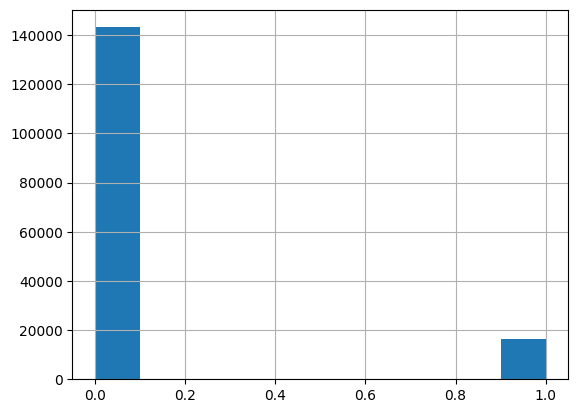

In [14]:
# Анализ целевого признака
data['toxic'].hist(); 

In [15]:
# Функция для предобработки текста.
# 1. Нижней регистр
# 2. Удаляем символы кроме a-z A-Z
# 3. Удаляем стоп-слова
def preprocess_text(texts):
    stop_words = set(stopwords.words('english'))
    regex = re.compile('[^a-z A-Z]')
    preprocess_texts = []
    for i in tqdm.tqdm(range(len(texts))):
        text = texts[i].lower()
        text = regex.sub(' ', text)
        word_tokens = word_tokenize(text)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        preprocess_texts.append(' '.join(filtered_sentence))

    return preprocess_texts

In [16]:
data.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            159441, 159442, 159443, 159444, 159445, 159446, 159447, 159448,
            159449, 159450],
           dtype='int64', length=159292)

In [17]:
data = data.reset_index(drop=True)

In [18]:
# Перед обработкой сбрасываю индексы, так как в первоночальном вареанте были пропуски в индексах.
data['preprocess_data'] = preprocess_text(data.text)

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [00:46<00:00, 3447.88it/s]


In [19]:
# Функция для Лемматизации
def lemmatize_texts(texts):
    nlp = spacy.load("en_core_web_sm")
    lem_text = []
    for text in tqdm.tqdm(texts):
        doc = nlp(text)
        lem_text.append(' '.join([token.lemma_ for token in doc]))
    return lem_text

In [20]:
data['data_lemmatize'] = lemmatize_texts(data.preprocess_data)

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [20:58<00:00, 126.55it/s]


In [21]:
print(data.preprocess_data[0])

explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired


In [22]:
print(data.data_lemmatize[0])

explanation edit make username hardcore metallica fan revert vandalism closure gas vote new york dolls fac please remove template talk page since retire


In [23]:
# Функция для Стеминга (выделим основу у слов)
def stemming_texts(texts, st=None):
    st = LancasterStemmer() if st is None else st
    stem_text = []
    for text in tqdm.tqdm(texts):
        word_tokens = word_tokenize(text)
        stem_text.append(' '.join([st.stem(word) for word in word_tokens]))
    return stem_text

In [24]:
data['data_stemming'] = stemming_texts(data.preprocess_data)

100%|████████████████████████████████████████████████████████████████████████| 159292/159292 [01:50<00:00, 1443.83it/s]


In [25]:
print(data.data_stemming[0])

expl edit mad usernam hardc metallic fan revert vand clos gas vot new york dol fac pleas remov templ talk pag sint retir


In [26]:
# Разделим датафрейм на три выборки: тренировачная, валидационная и тестовая
train, test_valid = train_test_split(data,
                                     stratify=data['toxic'],
                                     test_size=0.4,
                                     random_state=RANDOM_STATE)

In [27]:
valid, test = train_test_split(test_valid,
                               test_size=0.5,
                               random_state=RANDOM_STATE) 

In [28]:
print(train.shape, valid.shape, test.shape)

(95575, 5) (31858, 5) (31859, 5)


In [29]:
# Cоздадим мешки слов
vectorizer = CountVectorizer()

In [30]:
# Функция мешок слов
def bow(vectorizer, train, test):
    train_bow = vectorizer.fit_transform(train)
    test_bow = vectorizer.transform(test)
    return train_bow, test_bow

In [31]:
train.head()

,text,toxic,preprocess_data,data_lemmatize,data_stemming
13826,Because I want to say this qoute:\n\nSTOP CALL...,1,want say qoute stop calling name pathetic exus...,want say qoute stop call name pathetic exuse t...,want say qout stop cal nam pathet exus tricera...
20090,Balls: courage\nthis could definitely be a wik...,0,balls courage could definitely wikipedia entry...,ball courage could definitely wikipedia entry ...,bal cour could definit wikiped entry mak chang...
67200,"""\n\n Image:Redneckmower.jpg listed for deleti...",0,image redneckmower jpg listed deletion image m...,image redneckmower jpg list deletion image med...,im redneckmow jpg list delet im med fil upload...
16562,". Besides which, isn't this more an argument a...",0,besides argument chinese imperialism rather si...,besides argument chinese imperialism rather si...,besid argu chines imp rath sinoc tak due not o...
134789,ok your site already fucked so i cant fuck it ...,1,ok site already fucked cant fuck fuck nigga,ok site already fuck can not fuck fuck nigga,ok sit already fuck cant fuck fuck nigg


In [32]:
X_train_bow, X_valid_bow = bow(vectorizer,
                              train.text,
                              valid.text)

In [33]:
X_train_bow.shape

(95575, 139229)

In [34]:
X_valid_bow.shape

(31858, 139229)

In [35]:
# Мешок слов из текстов после предобработки
X_train_bow_preprocess, X_valid_bow_preprocess = bow(vectorizer,
                                                    train.preprocess_data,
                                                    valid.preprocess_data)

In [36]:
X_train_bow_preprocess.shape

(95575, 125368)

In [37]:
X_valid_bow_preprocess.shape

(31858, 125368)

In [38]:
# Мешок слов из текстов после лемматизации
X_train_bow_lemmatize, X_valid_bow_lemmatize = bow(vectorizer,
                                        train.data_lemmatize,
                                        valid.data_lemmatize)

In [39]:
X_train_bow_lemmatize.shape

(95575, 113700)

In [40]:
X_valid_bow_lemmatize.shape

(31858, 113700)

In [41]:
# Мешок слов из текстов после стеминга
X_train_bow_stem, X_valid_bow_stem = bow(vectorizer,
                                        train.data_stemming,
                                        valid.data_stemming)

In [42]:
X_train_bow_stem.shape

(95575, 82337)

In [43]:
X_valid_bow_stem.shape

(31858, 82337)

In [44]:
# Создаю матрицы cо значениями TF-IDF
vectorizer_tf_idf = TfidfVectorizer()

In [45]:
X_train_tfidf, X_valid_tfidf = bow(vectorizer_tf_idf,
                                  train.text,
                                  valid.text)

In [46]:
X_train_tfidf.shape

(95575, 139229)

In [47]:
X_train_tfidf_preprocess, X_valid_tfidf_preprocess = bow(vectorizer_tf_idf,
                                                        train.preprocess_data,
                                                        valid.preprocess_data)

In [48]:
X_train_tfidf_preprocess.shape

(95575, 125368)

In [49]:
X_train_tfidf_lemmatize, X_valid_tfidf_lemmatize = bow(vectorizer_tf_idf,
                                                        train.data_lemmatize,
                                                        valid.data_lemmatize)

In [50]:
X_train_tfidf_lemmatize.shape

(95575, 113700)

In [51]:
X_train_tfidf_stem, X_valid_tfidf_stem = bow(vectorizer_tf_idf,
                                            train.data_stemming,
                                            valid.data_stemming)

In [52]:
X_train_tfidf_stem.shape

(95575, 82337)

1. Загрузил данные. В датафрейме 159292 наблюдения без пропусков. В двух столбцах содержется текст комментария и целевой признак 0 или 1. Как и заявлено. Целевой признак несбалансированный с большим перевесов в пользу нуля. Учтем при делении на выборки.
2. Проевел предобработку декста: Нижней регистр; Удаляем символы кроме a-z A-Z; Удаляем стоп-слова.
3. Превел лемматизацию
4. Выделил основу у слов(стеминг)
5. Для сырого текста, для текста после обработки, лемматизации и стеминга создал мешки слов и матрицы cо значениями TF-IDF.

В итоге получил 8 полей признаков с мешками и матрицами TF-IDF

## Обучение

In [53]:
clf = LogisticRegression()

In [54]:
# Обучим модель логистической регрессиии
# Используем мешок слов из необработанных текстов
clf.fit(X_train_bow, train.toxic)
print('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_bow)))

LogisticRegression:  0.7643688140302136


In [55]:
# Обучим модель логистической регрессиии
# Используем мешок слов из предобработанных текстов
clf.fit(X_train_bow_preprocess, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_bow_preprocess)))

LogisticRegression:  0.7595599790466213


In [56]:
# Обучим модель логистической регрессиии
# Используем мешок слов из текста после лемматизации
clf.fit(X_train_bow_lemmatize, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_bow_lemmatize)))

LogisticRegression:  0.7569553805774278


In [57]:
# Обучим модель логистической регрессиии
# Используем мешок слов из текста после стеминга
clf.fit(X_train_bow_stem, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_bow_stem)))

LogisticRegression:  0.752280701754386


In [58]:
# Обучим модель логистической регрессиии
# Используем матрицу TF-IDF из необработанных текстов
clf.fit(X_train_tfidf, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_tfidf)))

LogisticRegression:  0.7222115569207141


In [59]:
# Обучим модель логистической регрессиии
# Используем матрицу TF-IDF из предобработанных текстов
clf.fit(X_train_tfidf_preprocess, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_tfidf_preprocess)))

LogisticRegression:  0.7203389830508474


In [60]:
# Обучим модель логистической регрессиии
# Используем матрицу TF-IDF из текста после лемматизации
clf.fit(X_train_tfidf_lemmatize, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_tfidf_lemmatize)))

LogisticRegression:  0.7334981928856762


In [61]:
# Обучим модель логистической регрессиии
# Используем матрицу TF-IDF из текста после стеминга
clf.fit(X_train_tfidf_stem, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf.predict(X_valid_tfidf_stem)))

LogisticRegression:  0.7397881996974282


In [62]:
clf_svc = LinearSVC()

In [63]:
# Обучим модель метод опорных векторов
# Используем мешок слов из необработанных текстов
clf_svc.fit(X_train_bow, train.toxic)
print ('LinearSVC: ', f1_score(valid.toxic, clf_svc.predict(X_valid_bow)))

LinearSVC:  0.7642013270755785


In [64]:
# Обучим модель метод опорных векторов
# Используем мешок слов из предобработанных текстов
clf_svc.fit(X_train_bow_preprocess, train.toxic)
print ('LinearSVC: ', f1_score(valid.toxic, clf_svc.predict(X_valid_bow_preprocess)))

LinearSVC:  0.7578641716405872


In [65]:
# Обучим модель метод опорных векторов
# Используем мешок слов из текста после лемматизации
clf_svc.fit(X_train_bow_lemmatize, train.toxic)
print ('LinearSVC: ', f1_score(valid.toxic, clf_svc.predict(X_valid_bow_lemmatize)))

LinearSVC:  0.7596169453010875


In [66]:
# Обучим модель метод опорных векторов
# Используем мешок слов из текста после стеминга
clf_svc.fit(X_train_bow_stem, train.toxic)
print ('LinearSVC: ', f1_score(valid.toxic, clf_svc.predict(X_valid_bow_stem)))

LinearSVC:  0.7557354925775979


In [67]:
# Обучим модель метод опорных векторов
# Используем матрицу TF-IDF из необработанных текстов
clf_svc.fit(X_train_tfidf, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf_svc.predict(X_valid_tfidf)))

LogisticRegression:  0.784938704028021


In [68]:
# Обучим модель метод опорных векторов
# Используем матрицу TF-IDF из предобработанных текстов
clf_svc.fit(X_train_tfidf_preprocess, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf_svc.predict(X_valid_tfidf_preprocess)))

LogisticRegression:  0.77111812127585


In [69]:
# Обучим модель метод опорных векторов
# Используем матрицу TF-IDF из текста после лемматизации
clf_svc.fit(X_train_tfidf_lemmatize, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf_svc.predict(X_valid_tfidf_lemmatize)))

LogisticRegression:  0.7743285664457621


In [70]:
# Обучим модель метод опорных векторов
# Используем матрицу TF-IDF из текста после стеминга
clf_svc.fit(X_train_tfidf_stem, train.toxic)
print ('LogisticRegression: ', f1_score(valid.toxic, clf_svc.predict(X_valid_tfidf_stem)))

LogisticRegression:  0.7773492286115007


Обучил 16 моделей ленейной регрессии и опорных векторов с разными полями признаков.

Лучше всего себя проявила модель метод опорных векторов с признаками матрица TF-IDF из необработанных текстов

In [71]:
# Проверим лучшую модель на тестовой выборке.
X_train_tfidf, X_test_tfidf = bow(vectorizer_tf_idf,
                                  train.text,
                                  test.text)
clf_svc.fit(X_train_tfidf, train.toxic)
print ('LogisticRegression: ', f1_score(test.toxic, clf_svc.predict(X_test_tfidf)))

LogisticRegression:  0.7852130754749272


Полученные значение метрики F1 = 0.7852 удовлетворяют условиям проекта

## Выводы

Целью проекта является обучить модель классифицировать комментарии на позитивные и негативные.

* Загрузил данные. В датафрейме 159292 наблюдения без пропусков. В двух столбцах содержется текст комментария и целевой признак 0 или 1. Как и заявлено. Целевой признак несбалансированный с большим перевесов в пользу нуля. Учтем при делении на выборки.
* Проевел предобработку декста: Нижней регистр; Удаляем символы кроме a-z A-Z; Удаляем стоп-слова.
* Выделил основу у слов(стеминг)
* Для сырого текста, для текста после обработки, посли лемматизации и стеминга создал мешки слов и матрицы cо значениями TF-IDF
  
В итоге получил 8 полей признаков с мешками и матрицами TF-IDF.

Обучил 16 моделей ленейной регрессии и опорных векторов с разными полями признаков.

Лучше всего себя проявила модель метод опорных векторов с признаками матрица TF-IDF из необработанных текстов
с метроикой F1 = 0.7852. Это удовлетворяет условиям проекта. Эту модель предлагаю в качестве решения.